Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v4 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


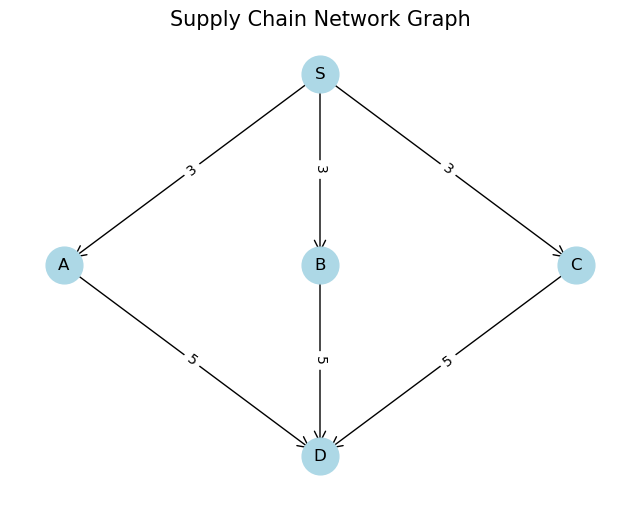

In [4]:
env.render_network()

In [5]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [6]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

Episode Length: 1
Stock Level: [23.7 23.8 22.8]
Planned Demand: [ 5.3  5.8 11.4]
Actual Demand: [6.3 4.2 9.2]
Action: [ 9.3  2.6 26.5]
Order: [0 0 0]
Reward: -708.5581155980309

Episode Length: 2
Stock Level: [23.7 23.8 22.8]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [ 2.2 48.9 31.3]
Order: [0 0 0]
Reward: -1461.2102289129652

Episode Length: 3
Stock Level: [23.7 17.2 22.8]
Planned Demand: [0.  8.4 0. ]
Actual Demand: [0.  6.6 0. ]
Action: [32.2 14.2 36.9]
Order: [0 0 0]
Reward: -2208.2224290669446

Episode Length: 4
Stock Level: [33.   7.3 49.2]
Planned Demand: [ 0.  12.4  0. ]
Actual Demand: [ 0.  12.5  0. ]
Action: [48.2  8.1 18.6]
Order: [ 9.3  2.6 26.5]
Reward: -2972.59727888047

Episode Length: 5
Stock Level: [27.4 56.1 68.9]
Planned Demand: [ 7.1  0.  11.4]
Actual Demand: [ 7.8  0.  11.7]
Action: [27.7 26.7 42.5]
Order: [ 2.2 48.9 31.3]
Reward: -3822.0052500624406

Episode Length: 6
Stock Level: [50.  63.3 95.2]
Planned Demand: [ 8.8  7.3 12. ]
Actual Demand: 

**Train Model**


In [7]:
log_path = os.path.join('Training', 'Logs')
# model_path = os.path.join('Training', 'Models', 'PPO')
model_path = os.path.join('Training', 'Models', 'A2C')

In [8]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

num_envs = 8

# dummy_env = DummyVecEnv(make_env, n_envs=num_envs)
vec_env = make_vec_env(make_env, n_envs=num_envs)

# model = PPO("MlpPolicy", 
#             dummy_env,
#             learning_rate = 0.0007,
#             gamma = 0.99,
#             verbose=1,
#             tensorboard_log=log_path)

model = A2C("MlpPolicy",
            vec_env,
            learning_rate = 0.0005,
            gamma = 0.99,
            verbose=1,
            tensorboard_log=log_path)

Using cpu device


In [9]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/A2C_10
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -5.14e+05 |
| time/                 |           |
|    fps                | 8646      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -4.25     |
|    explained_variance | 1.19e-06  |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | -1.55e+05 |
|    std                | 0.997     |
|    value_loss         | 1.46e+09  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -4.71e+05 |
| time/                 |           |
|    fps                | 9156      |
|    iterations         | 200       |
|    time_elapsed 

In [10]:
model.save(model_path)
model.load(model_path)

evaluate_policy(model, vec_env, n_eval_episodes=10, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [30.  20.1 32. ]
Planned Demand: [0.  5.4 0. ]
Actual Demand: [0.  7.9 0. ]
Action: [26.1 17.6 10.7]
Order: [0 0 0]
Reward: -736.5875396425821

Episode Length: 1
Stock Level: [22.6 21.9 32. ]
Planned Demand: [9.3 9.1 0. ]
Actual Demand: [7.4 6.1 0. ]
Action: [27.  15.6 10.8]
Order: [0 0 0]
Reward: -729.8724815215883

Episode Length: 1
Stock Level: [22.2 18.3 21.3]
Planned Demand: [ 4.7 10.4 12.2]
Actual Demand: [ 7.8  9.7 10.7]
Action: [26.7 17.9  7.7]
Order: [0 0 0]
Reward: -714.1900749635496

Episode Length: 1
Stock Level: [30.  28.  22.6]
Planned Demand: [0.  0.  9.4]
Actual Demand: [0.  0.  9.4]
Action: [26.3 16.2  5.3]
Order: [0 0 0]
Reward: -728.3820779651392

Episode Length: 1
Stock Level: [30. 28. 14.]
Planned Demand: [ 0.   0.  14.8]
Actual Demand: [ 0.  0. 18.]
Action: [27.3 16.5  7. ]
Order: [0 0 0]
Reward: -722.8783607195486

Episode Length: 1
Stock Level: [21.8 28.  18.2]
Planned Demand: [10.2  0.  12.3]
Actual Demand: [ 8.2  0.  13.8]
Action

([-470199.566769,
  -451202.069168,
  -466014.937706,
  -445972.168289,
  -523969.658994,
  -491191.301636,
  -486311.488692,
  -443127.395342,
  -472880.310691,
  -463062.22447],
 [30, 30, 30, 30, 30, 30, 30, 30, 30, 30])

In [11]:
df = pd.read_csv('./Data/2024-10-14_20_last_environment_data.csv')

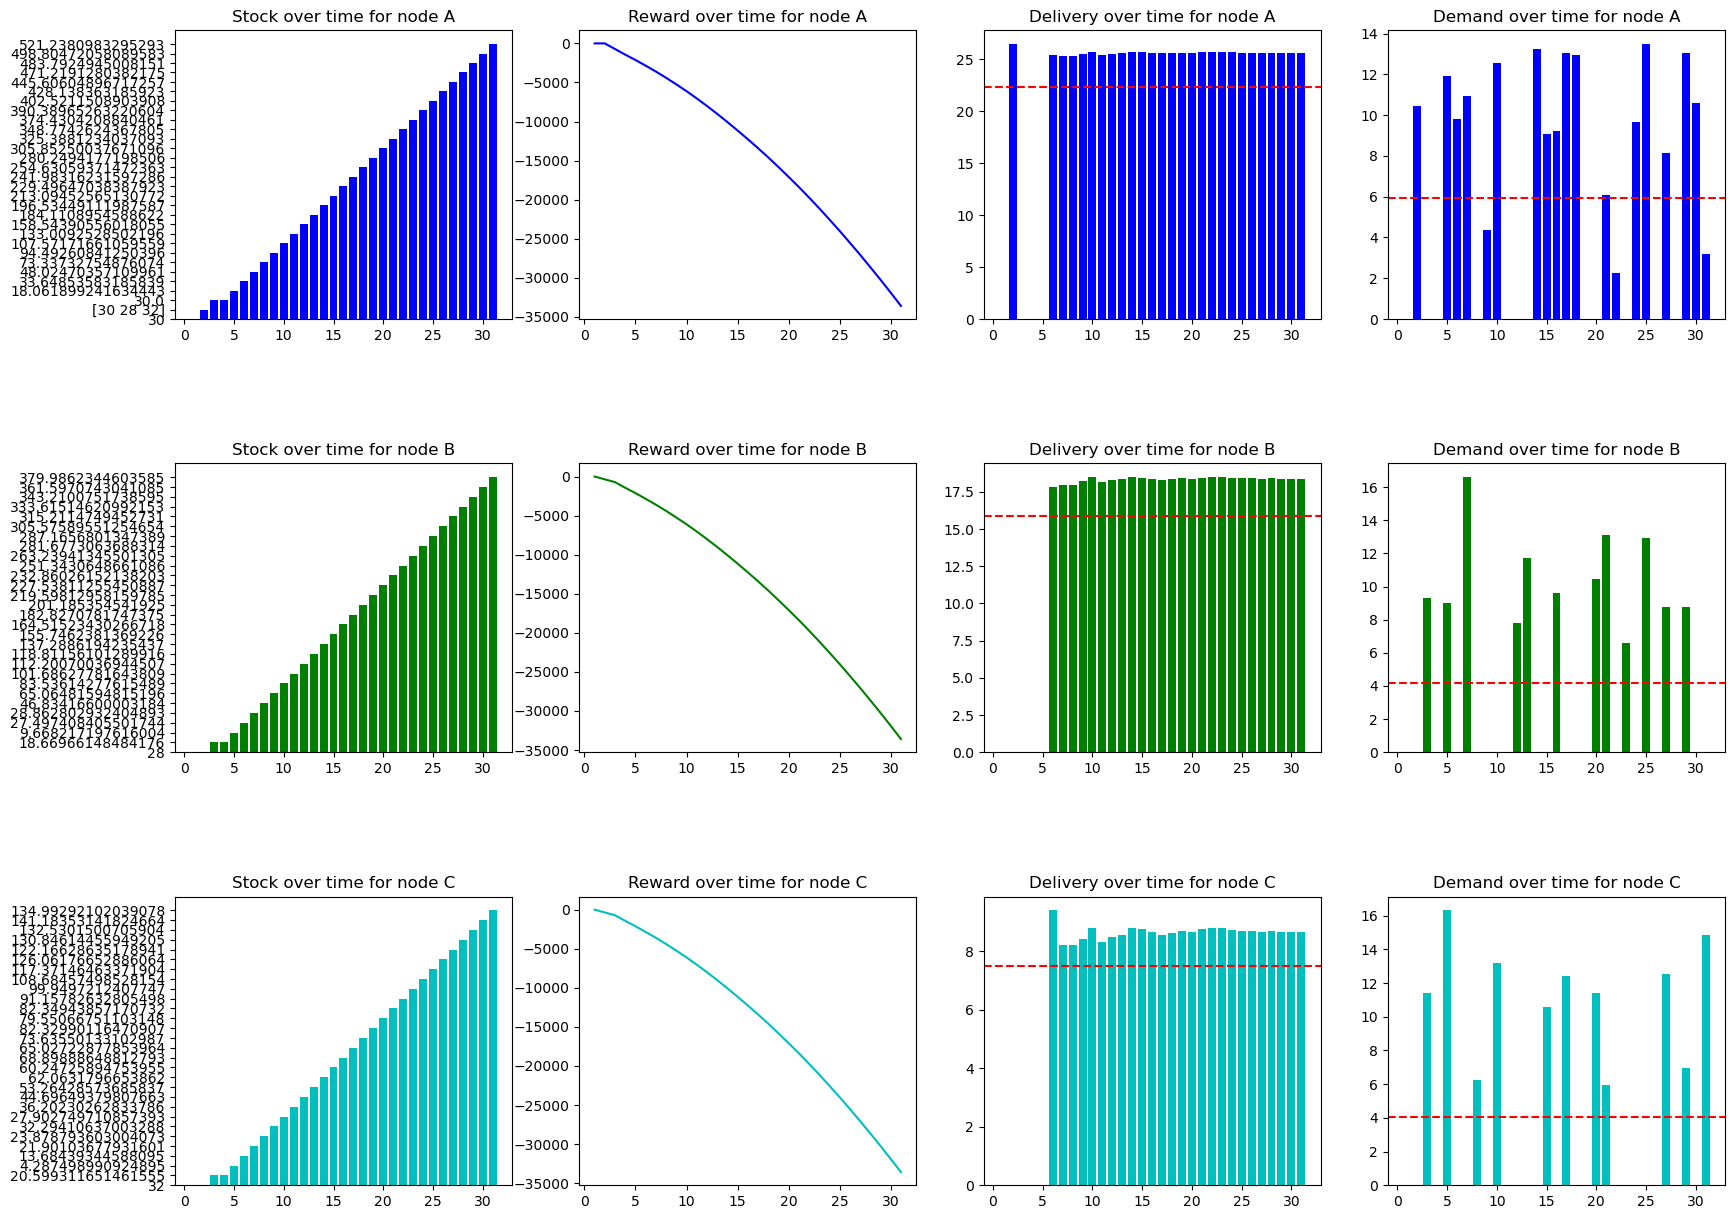

In [12]:
plot_data(df)